In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

/var/folders/8v/z7_lynrn24bbpwy6p36j3cwc0000gn/T/ipykernel_31449/3168014724.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/chaiharsha/Documents/course_classifier/courseenvfull/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("courses.csv")
pd.set_option('display.max_rows', None)
df.head()

,Course,ID,Department
0,Principles of Nutrition,BIOL,Biology
1,Nutrition for Fitness and Physical Activity,BIOL,Biology
2,Introduction to Human Physiology,BIOL,Biology
3,Biotechnology Management,BIOL,Biology
4,Living Biology at Brown and Beyond,BIOL,Biology


In [4]:
counts = df['Department'].value_counts()
df['Department'].value_counts()

Department
English                             561
History                             380
Political Science                   316
Engineering                         264
Comparative Literature              245
Modern Culture and Media            237
American Studies                    217
Sociology                           210
Anthropology                        203
Computer Science                    199
Music                               188
Art History                         183
Religious Studies                   179
Applied Mathematics                 174
Biology                             170
Theater and Performance             148
Economics                           148
Philosophy                          138
Africana Studies                    135
Public Health                       131
Geology                             127
Archaeology                         126
German                              121
International and Public Affairs    109
Classics                     

In [ ]:
department_mapping = {
    'History': 'History & Social Sciences',
    'Political Science': 'History & Social Sciences',
    'International and Public Affairs': 'History & Social Sciences',
    'Sociology': 'History & Social Sciences',
    'Anthropology': 'History & Social Sciences',
    'Africana Studies': 'History & Social Sciences',
    'Public Health': 'History & Social Sciences',
    'Economics': 'History & Social Sciences',
    'Education': 'History & Social Sciences',
    'Gender and Sexuality Studies': 'History & Social Sciences',
    'Urban Studies': 'History & Social Sciences',

    'Mathematics': 'STEM',
    'Applied Mathematics': 'STEM',
    'Physics': 'STEM',
    'Engineering': 'STEM',
    'Computer Science': 'STEM',
    'Biology': 'STEM',
    'Neuroscience': 'STEM',
    'Chemistry': 'STEM',
    'Geology': 'STEM',
    'Data Science': 'STEM',
    'Environmental Studies': 'STEM',

    'Modern Culture and Media': 'Arts & Media',
    'Music': 'Arts & Media',
    'Theater and Performance': 'Arts & Media',
    'Visual Art': 'Arts & Media',
    'Art History': 'Arts & Media',
    'Arts Institute': 'Arts & Media',
    'English': 'Arts & Media',
    'Comparative Literature': 'Arts & Media',

    'Philosophy': 'Philosophy & Religion',
    'Religious Studies': 'Philosophy & Religion',
    'Contemplative Studies': 'Philosophy & Religion',
    'Judaic Studies': 'Philosophy & Religion',

    'Latin': 'Languages',
    'Ancient Greek': 'Languages',
    'German': 'Languages',
    'Russian': 'Languages',
    'Italian': 'Languages',
    'Portuguese and Brazilian Studies': 'Languages',
    'East Asian Studies': 'Languages',
    'Chinese': 'Languages',
    'Japanese': 'Languages',
    'Korean': 'Languages',
    'Hindi-Urdu': 'Languages',
    'Arabic': 'Languages',
    'Sanskrit': 'Languages',
    'Persian': 'Languages',
    'Swedish': 'Languages',
    'Catalan': 'Languages',
    'Vietnamese': 'Languages',
    'Polish': 'Languages',
    'Hebrew': 'Languages',
    'Turkish': 'Languages',
    'Yoruba': 'Languages',
    'Czech': 'Languages',
    'Language Studies': 'Languages',
    'Native American Studies': 'Languages',

    'Egyptology': 'Ancient Studies',
    'Assyriology': 'Ancient Studies',
    'Classics': 'Ancient Studies',
    'Archaeology': 'Ancient Studies',
    'Early Cultures': 'Ancient Studies',
    'Medeival Studies': 'Ancient Studies',

    'Other': 'Other'
}

In [74]:
df['Department_Grouped'] = df['Department'].map(department_mapping).fillna('Other')
df['Department_Grouped'].value_counts()

NameError: name 'department_mapping' is not defined

In [5]:
labels_text = df['Department']
text = df['Course']

In [6]:
text_list = text.tolist()
tokenizer_pretrained = AutoTokenizer.from_pretrained("bert-base-uncased")
encoded = tokenizer_pretrained(text_list, padding=True, return_tensors="np")
sequences_pretrained = encoded['input_ids']
print(sequences_pretrained.shape)
max_length_pretrained = sequences_pretrained.shape[1]

(6690, 26)


In [7]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels_text) 

In [8]:
one_hot_labels = keras.utils.to_categorical(labels)
print(one_hot_labels.shape)

(6690, 77)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(sequences_pretrained, one_hot_labels, test_size=0.2, random_state=17)

In [10]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

In [13]:
embedding_dim = 100
vocab = tokenizer_pretrained.get_vocab()
vocab_size = len(vocab) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [14]:
trainable = True
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length_pretrained, trainable=trainable),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 100)           3052300   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 77)                9933      
                                                                 
Total params: 3146713 (12.00 MB)
Trainable params: 3146713 (12.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)

Epoch 1/25
168/168 [==============================] - 4s 18ms/step - loss: 3.8849 - accuracy: 0.0826 - val_loss: 3.7494 - val_accuracy: 0.1099
Epoch 2/25
168/168 [==============================] - 3s 17ms/step - loss: 3.3302 - accuracy: 0.1895 - val_loss: 2.9783 - val_accuracy: 0.2765
Epoch 3/25
168/168 [==============================] - 3s 16ms/step - loss: 2.2922 - accuracy: 0.4488 - val_loss: 2.5510 - val_accuracy: 0.3939
Epoch 4/25
168/168 [==============================] - 3s 16ms/step - loss: 1.6025 - accuracy: 0.6274 - val_loss: 2.4948 - val_accuracy: 0.4126
Epoch 5/25
168/168 [==============================] - 3s 18ms/step - loss: 1.1692 - accuracy: 0.7229 - val_loss: 2.4303 - val_accuracy: 0.4454
Epoch 6/25
168/168 [==============================] - 3s 17ms/step - loss: 0.8840 - accuracy: 0.7877 - val_loss: 2.4339 - val_accuracy: 0.4604
Epoch 7/25
168/168 [==============================] - 3s 16ms/step - loss: 0.6834 - accuracy: 0.8401 - val_loss: 2.5082 - val_accuracy: 0.4611

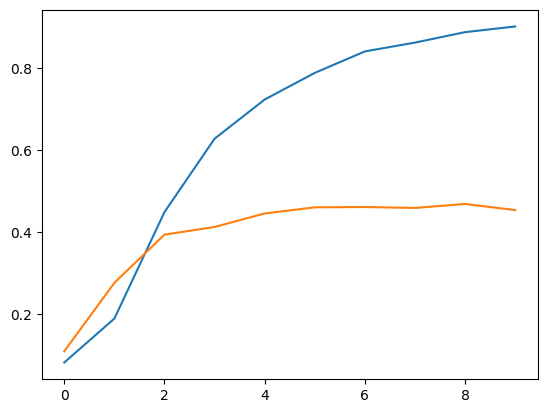

In [17]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

In [21]:
predict_text = ["Computational Statistics"]
predict_seq = tokenizer_pretrained(predict_text, padding='max_length', max_length=max_length_pretrained, return_tensors="np")['input_ids']
predictions = model.predict(predict_seq)

# Print probability diestribution
predictions = pd.DataFrame(predictions, columns=label_encoder.classes_)
pred_series = predictions.iloc[0]
top_5 = pred_series.sort_values(ascending=False).head(5)
print("Top 5 Predicted Departments:")
for dept, prob in top_5.items():
    print(f"{dept}: {prob:.4f}")

predicted_labels = np.argmax(predictions, axis=1)
predicted_labels_text = label_encoder.inverse_transform(predicted_labels)
for text, label in zip(predict_text, predicted_labels_text):
    print(f"Text: {text} => Predicted Label: {label}")

1/1 [==============================] - 0s 14ms/step
Top 5 Predicted Departments:
Applied Mathematics: 0.5323
Computer Science: 0.1802
Mathematics: 0.0758
Geology: 0.0567
Physics: 0.0268
Text: Computational Statistics => Predicted Label: Applied Mathematics


In [22]:
model.save('lstm_tf_pretrainedtokenizer.h5')

/Users/chaiharsha/Documents/course_classifier/courseenvfull/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
